# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


Train the `KNeighborsClassifier` on the dataset.

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
all_data = pd.read_csv('forest_dataset.csv')
all_data.head()
all_data.shape
labels = all_data.iloc[:, -1].values
feature_matrix = all_data.iloc[:, :-1].values
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size=0.2, random_state=42)
n_neighbors = 5
metric = 'euclidean'
weights = 'uniform'
knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность: {accuracy:.4f}')

Точность: 0.7365


Let's select the parameters of our model:

* Iterate over the grid from `1` to `10` for the number of neighbors parameter
* Also, try using different metrics: `['manhattan', 'euclidean']`
* Try using different weight calculation strategies: `[‘uniform’, ‘distance’]`

In [2]:
import numpy as np
from sklearn.model_selection import GridSearchCV
params = {
    "n_neighbors": np.arange(1, 11),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "euclidean"]
}
clf = KNeighborsClassifier()
clf_grid = GridSearchCV(clf, params, cv=5, scoring="accuracy", n_jobs=-1)
train = clf_grid.fit(feature_matrix, labels)

Let's output the best parameters

In [3]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

Using the optimal number of neighbors found, calculate the probabilities of belonging to classes for the test sample (`.predict_proba`).

In [4]:
optimal_clf = KNeighborsClassifier(**clf_grid.best_params_)
optimal_clf.fit(X_train, y_train)
pred_prob = optimal_clf.predict_proba(X_test)
print('Вероятности принадлежности к классам для тестовых образцов:\n', pred_prob)

Вероятности принадлежности к классам для тестовых образцов:
 [[0.         1.         0.         ... 0.         0.         0.        ]
 [0.73117861 0.26882139 0.         ... 0.         0.         0.        ]
 [0.27814042 0.72185958 0.         ... 0.         0.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.54264548 0.         0.         ... 0.         0.         0.45735452]]


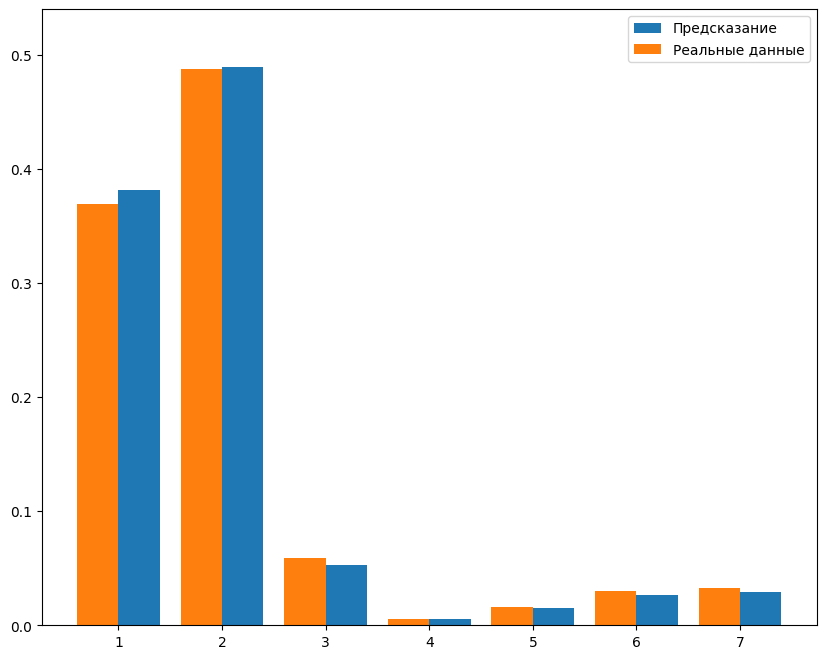

In [5]:
import matplotlib.pyplot as plt
unique, freq = np.unique(labels, return_counts=True)
freq = list(map(lambda x: x / len(labels),freq))
pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='Предсказание')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='Реальные данные')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

## Conclusion

What is the quality of the model on the test sample? Compare it with the quality of logistic regression. Which model is better? Why? What are the pros and cons of the k Nearest Neighbors method? Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

In [6]:
y_pred = optimal_clf.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
print(f'Точность: {knn_accuracy:.4f}')

Точность: 0.7850


In [7]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1, solver='liblinear')
clf.fit(feature_matrix, labels)
y_pred = clf.predict(feature_matrix)
log_accuracy = accuracy_score(labels, y_pred)
print(f'Точность: {log_accuracy:.4f}')

Точность: 0.7113


Точность модели KNN оказалась выше, чем у логистической регрессии. 
KNN является непараметрической моделью, что означает, что она не делает предположений о форме распределения данных и может эффективно справляться с различными типами структур данных. Она также учитывает локальные особенности, что делает её мощным инструментом для задач, где важны такие паттерны, которые не могут быть легко захвачены линейными методами. \
Преимущества KNN:
1. Отсутствие необходимости в обучении: KNN не требует явного обучения на этапе подготовки модели, так как оно выполняется в момент классификации. Это делает его простым для применения на новых данных.

2. Гибкость: KNN может легко адаптироваться к различным типам задач, включая многоклассовую классификацию и задачи регрессии. Он также не ограничен линейной моделью и может справляться с нелинейно разделимыми данными.

3. Хорошо работает с небольшими данными: если данных не слишком много, KNN может быть очень точным, так как он анализирует конкретные примеры и принимает решения на основе близости.

Недостатки KNN:
1. Чувствительность к масштабу данных: KNN чувствителен к масштабированию признаков. Если данные не нормализованы, алгоритм может не дать хороших результатов, так как расстояния между точками будут зависеть от масштаба признаков.

2. Вычислительная сложность: для каждого тестового примера необходимо вычислять расстояния до всех обучающих примеров, что может быть очень медленно при большом объёме данных.

3. Проблемы с высокоразмерными данными: в задачах с большим количеством признаков (высокая размерность) KNN может сталкиваться с проблемой, известной как "проклятие размерности", когда расстояния между точками становятся менее информативными.

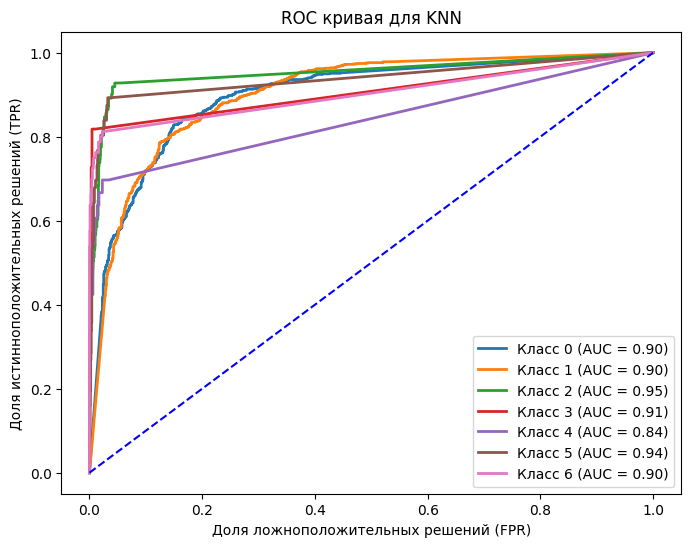

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Класс {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('Доля ложноположительных решений (FPR)')
plt.ylabel('Доля истинноположительных решений (TPR)')
plt.title('ROC кривая для KNN')
plt.legend(loc='lower right')
plt.show()